In [1]:
import numpy as np
from numpy import genfromtxt
import csv
import os

import pysindy as ps

import deepSI
from deepSI import System_data

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = r"data\\"

WIENER = "WienerHammerBenchmark"
SILVER = "SNLS80mV"
OGDATA = "OG-1-1-11"
# change data set
DATA = OGDATA
CSV = ".csv"

PATH = os.path.join(DATA_PATH, DATA+CSV)

# load data
data = genfromtxt(PATH, delimiter=",")

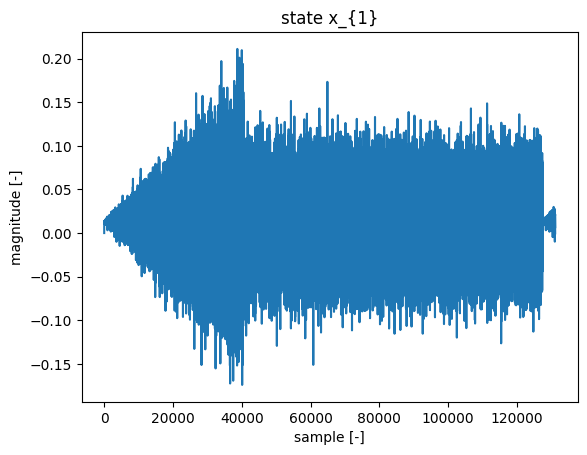

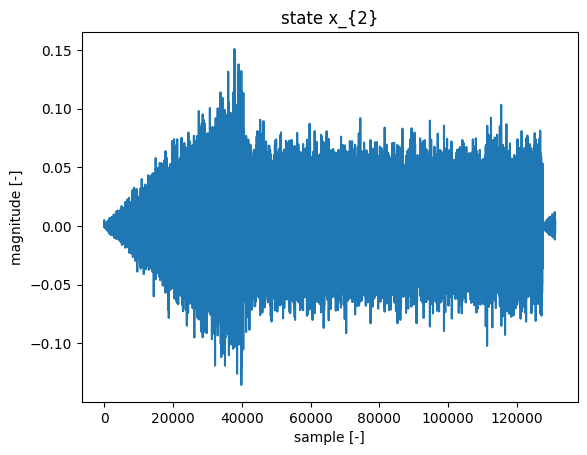

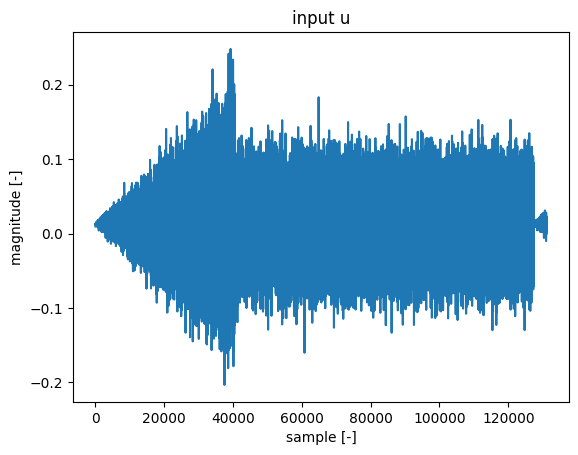

In [5]:
# data
x1 = data[:,0]
x2 = data[:,1]
u = data[:,2]

N = x1.shape[0]
fs = 610.35
dt = 1/fs
t = np.linspace(0,dt*N,N)

plt.plot(x1)
plt.xlabel("sample [-]")
plt.ylabel("magnitude [-]")
plt.title("state x_{1}")
plt.show()

plt.plot(x2)
plt.xlabel("sample [-]")
plt.ylabel("magnitude [-]")
plt.title("state x_{2}")
plt.show()

plt.plot(u)
plt.xlabel("sample [-]")
plt.ylabel("magnitude [-]")
plt.title("input u")
plt.show()

In [7]:
silver_data = System_data(u=u,y=np.stack((x1, x2), axis=-1))

train, test = silver_data.train_test_split(split_fraction=0.2)
print("Training samples: ", train.y.shape[0])
print("Test samples: ", test.y.shape[0])

time = t[0:train.y.shape[0]]

Training samples:  104857
Test samples:  26215


In [9]:
def NRMS(y_pred, y_true):
    RMS = np.sqrt(np.mean((y_pred-y_true)**2))
    return RMS/np.std(y_true)

In [28]:
# differentiation_method = ps.SINDyDerivative(kind="spline", s=1e-2)
differentiation_method = ps.FiniteDifference(order=4)

x_train = train.y

# model specs
feature_library = ps.ConcatLibrary([ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),

stlsq_optimizer = ps.STLSQ(verbose=True)#, threshold= 0.03

model = ps.SINDy(feature_library=feature_library,
                 optimizer=stlsq_optimizer,
                 discrete_time=True
                 )
# fit
model.fit(x_train, u=train.u, t=dt)
model.print()
model.coefficients()

x_test = test.y
x_dot_test_predicted = model.predict(x_test, u=test.u)

x_dot_test_simulated = model.simulate(x_test[0], u=test.u, t=test.u.shape[0])

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.2908e-03 ... 7.0908e-02 ...          6 ... 7.2199e-02
         1 ... 1.2431e-03 ... 7.0908e-02 ...          6 ... 7.2152e-02
(x0)[k+1] = 0.658 x0[k] + 0.533 x1[k] + 0.340 u0[k]
(x1)[k+1] = -0.536 x0[k] + 0.125 x1[k] + 0.533 u0[k]


NRMS pred 1:  0.0011563891915617496
NRMS simo 1:  0.003271013647243975


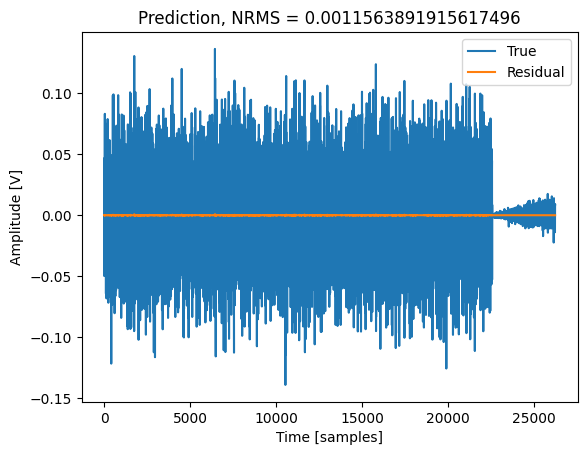

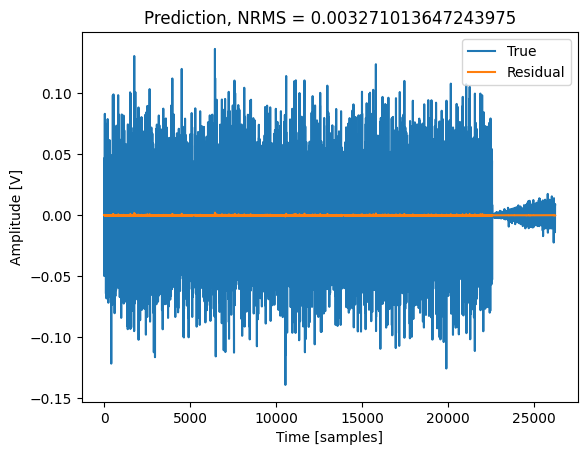

In [29]:
pred_NRMS = NRMS( x_dot_test_predicted[:-1,0], test.y[1:,0])
simo_NRMS = NRMS( x_dot_test_simulated[:,0], test.y[:,0])

print("NRMS pred 1: ",pred_NRMS)
print("NRMS simo 1: ",simo_NRMS)

plt.plot(test.y[:,0]-np.mean(test.y[:,0]))
plt.plot(x_dot_test_predicted[:-1,0]-test.y[1:,0])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(pred_NRMS))
plt.legend(["True","Residual"])
plt.show()

plt.plot(test.y[:,0]-np.mean(test.y[:,0]))
plt.plot(x_dot_test_simulated[:,0]-test.y[:,0])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(simo_NRMS))
plt.legend(["True","Residual"])
plt.show()

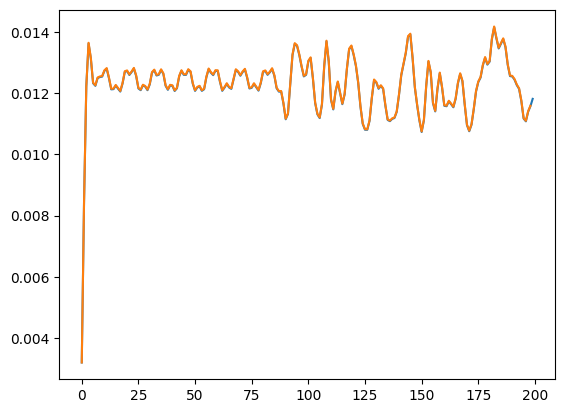

In [48]:
x_dot_train_predicted = model.predict(x_train, u=train.u)
plt.plot(x_dot_train_predicted[:200,0])
plt.plot(x1[1:200])
# plt.plot(x_dot_train_predicted[:200,0]-x1[:200])
plt.show()